Using cache found in /public_bme2/bme-dgshen/ZhaoyuQiu/.cache/hub/facebookresearch_dinov2_main


Segmentation Output Shape: torch.Size([1, 4, 224, 224])


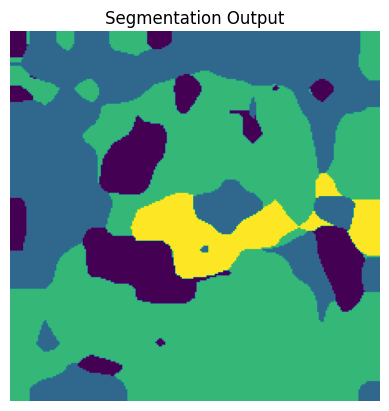

In [7]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# 设置 TORCH_HOME
os.environ['TORCH_HOME'] = '/public_bme2/bme-dgshen/ZhaoyuQiu/.cache'

# 加载 DINOv2 模型
backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
backbone.eval()  # 设置为评估模式


# 定义分割模型
class DinoSegmentationModel(nn.Module):
    def __init__(self, backbone, num_classes=4):
        super(DinoSegmentationModel, self).__init__()
        self.backbone = backbone  # DINOv2 特征提取器
        self.decoder = nn.Sequential(
            nn.Conv2d(768, 256, kernel_size=3, padding=1),  # 特征通道降维
            nn.ReLU(),
            nn.Conv2d(256, num_classes, kernel_size=1)      # 输出类别数
        )

    def forward(self, x):
        # 提取 DINOv2 特征
        features = self.backbone.forward_features(x)["x_norm_patchtokens"]
        batch_size, num_patches, channels = features.shape

        # 重塑特征为 2D 格式 (B, C, H, W)
        h = w = int(num_patches ** 0.5)  # 假设输入为 224x224，输出 14x14 的特征图
        features = features.permute(0, 2, 1).view(batch_size, channels, h, w)

        # 解码到像素级分割结果
        output = self.decoder(features)
        return nn.functional.interpolate(output, size=(224, 224), mode='bilinear', align_corners=False)


# 创建模型实例
model = DinoSegmentationModel(backbone, num_classes=4)
model.eval()


# 数据预处理
transform = T.Compose([
    T.Resize((224, 224)),  # 调整输入大小
    T.ToTensor(),          # 转换为张量
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 使用实际图片作为输入
image_path = "/public_bme2/bme-dgshen/ZhaoyuQiu/CS276_Final_Project/test.png"  # 替换为实际图片路径
input_image = Image.open(image_path).convert("RGB")  # 确保图像为 RGB 格式

# 应用预处理
input_tensor = transform(input_image).unsqueeze(0)  # 增加 batch 维度

# 模型前向传播
with torch.no_grad():
    segmentation_output = model(input_tensor)

# 输出结果形状
print("Segmentation Output Shape:", segmentation_output.shape)


# 可视化分割结果
def visualize_segmentation(output):
    # 获取预测的类别
    predicted_masks = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # 显示分割结果
    plt.imshow(predicted_masks, cmap='viridis')
    plt.title("Segmentation Output")
    plt.axis('off')
    plt.show()


# 可视化分割结果
visualize_segmentation(segmentation_output)


In [2]:
print(os.environ)

environ({'MANPATH': '/opt/gridview/pmix/share/pmix:/opt/gridview/slurm/share/man:/opt/gridview/munge/share/man:/opt/gridview/pmix/share/pmix:/opt/gridview/slurm/share/man:/opt/gridview/munge/share/man:', 'HOSTNAME': 'bme_login2', 'SSL_CERT_FILE': '/etc/pki/ca-trust/extracted/pem/tls-ca-bundle.pem', 'SLURM_PMIX_DIRECT_CONN_UCX': 'false', 'SHELL': '/bin/bash', 'HISTSIZE': '4096', 'SSH_CLIENT': '10.19.126.99 57381 22112', 'FSLMULTIFILEQUIT': 'TRUE', 'CONDA_SHLVL': '2', 'PERL5LIB': '/home_data/home/qiuzhy2024/perl5/lib/perl5:', 'CONDA_PROMPT_MODIFIER': '(dinov2) ', 'PYTHONUNBUFFERED': '1', 'FSL_SKIP_GLOBAL': '0', 'QTDIR': '/usr/lib64/qt-3.3', 'QTINC': '/usr/lib64/qt-3.3/include', 'PERL_MB_OPT': '--install_base /home_data/home/qiuzhy2024/perl5', 'QT_GRAPHICSSYSTEM_CHECKED': '1', 'VSCODE_HANDLES_SIGPIPE': 'true', 'USER': 'qiuzhy2024', 'PYTHONIOENCODING': 'utf-8', 'LD_LIBRARY_PATH': '/opt/gridview/pmix/lib:/opt/gridview/slurm/lib:/opt/gridview/slurm/lib64:/opt/gridview/munge/lib:/opt/gridview

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("dark_background")

def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap="Greys")
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

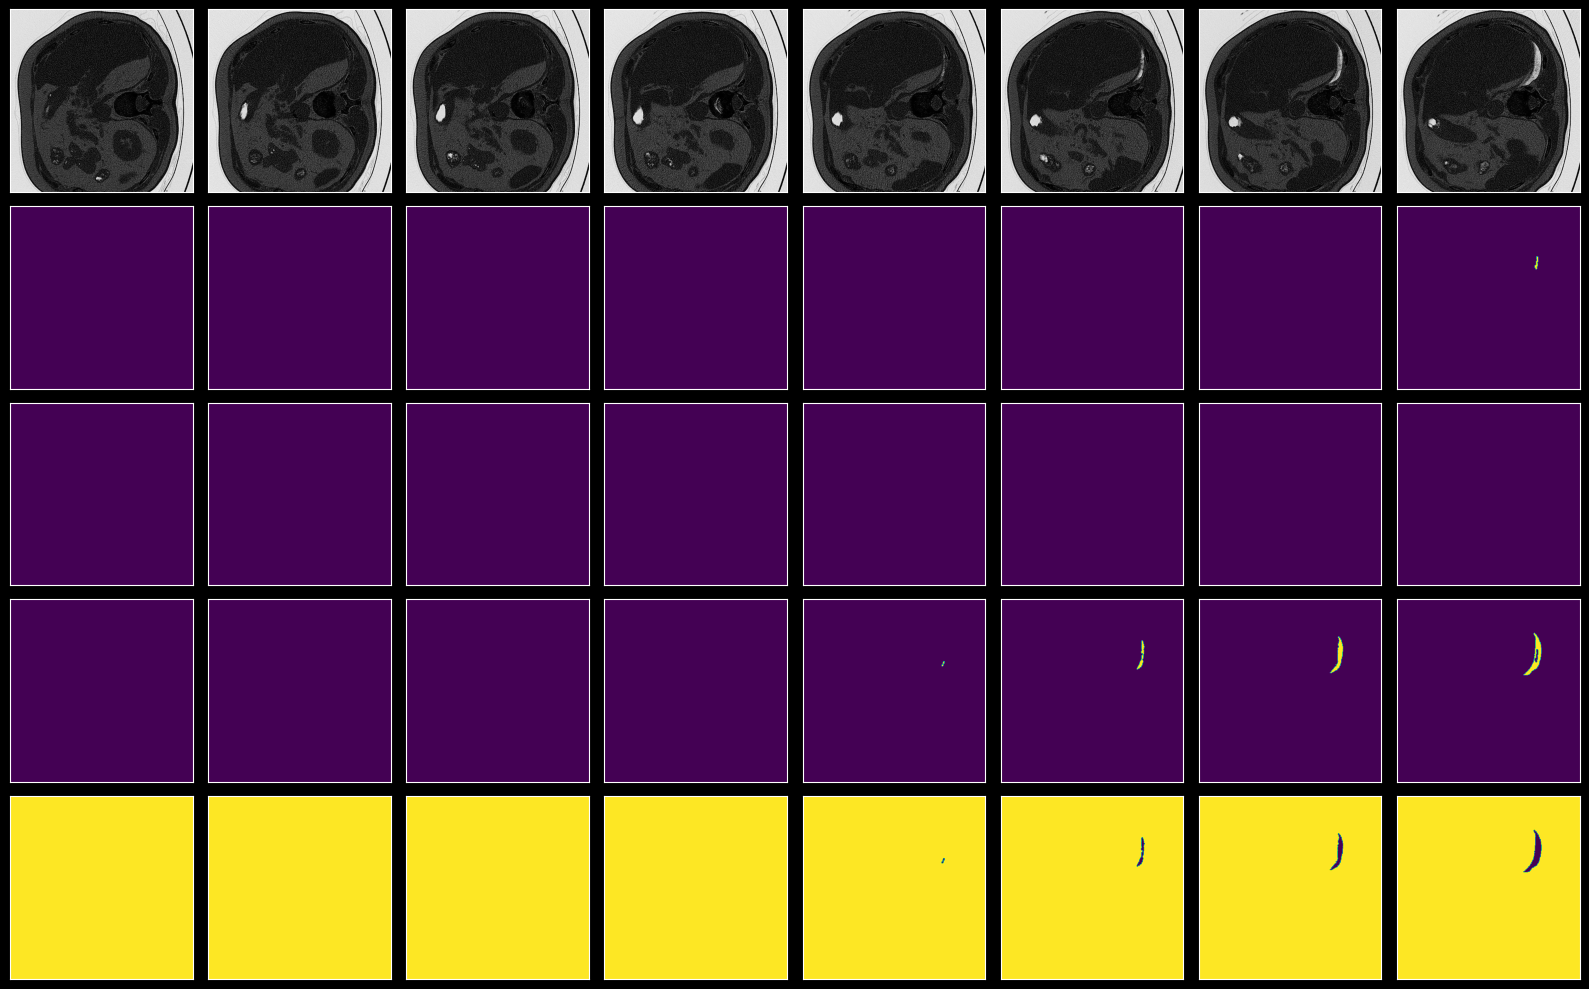

In [15]:
DIR_PATH = "/public_bme2/bme-dgshen/ZhaoyuQiu/.cache/covid-segmentation/"

# TRAIN_X_FILE = "images_medseg.npy"
# TRAIN_Y_FILE = "masks_medseg.npy"

TRAIN_X_FILE = "images_radiopedia.npy"
TRAIN_Y_FILE = "masks_radiopedia.npy"

imgs_medseg = np.load(DIR_PATH+TRAIN_X_FILE).astype(np.float32)
msks_medseg = np.load(DIR_PATH+TRAIN_Y_FILE).astype(np.float32)
visualize(imgs_medseg, msks_medseg)

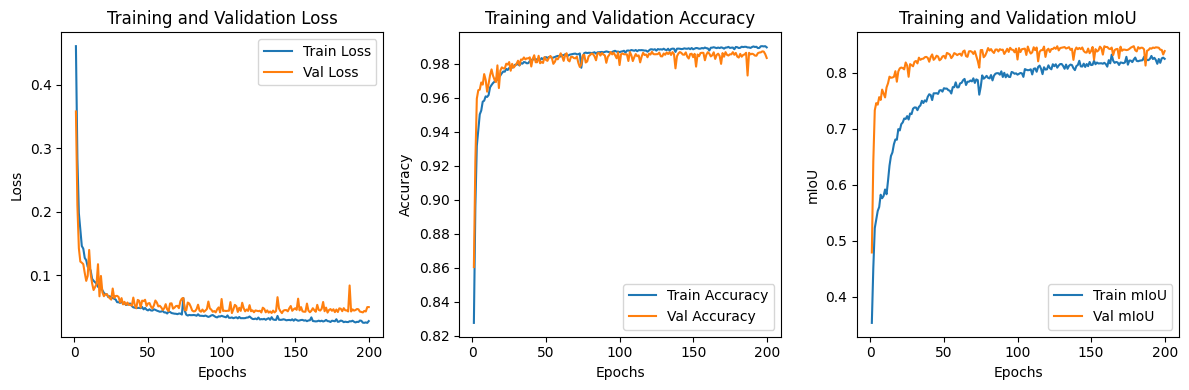

In [2]:
import pickle
# 从 .pkl 文件加载 history
with open('/public_bme2/bme-dgshen/ZhaoyuQiu/CS276_Final_Project/UNet_history.pkl', 'rb') as file:
    history = pickle.load(file)

import matplotlib.pyplot as plt

def plot_history(history):
    """
    绘制训练过程中的损失、准确率、和mIoU。
    Args:
        history: 包含训练和验证的loss、accuracy、mIoU的字典。
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    # 绘制 Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # 绘制 Pixel Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    # 绘制 mIoU
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["train_miou"], label="Train mIoU")
    plt.plot(epochs, history["val_miou"], label="Val mIoU")
    plt.xlabel("Epochs")
    plt.ylabel("mIoU")
    plt.title("Training and Validation mIoU")
    plt.legend()

    plt.tight_layout()
    plt.show()

# 假设 `history` 是从 train_model 函数返回的字典
# 调用 plot_history 函数
# 示例：
plot_history(history)


In [7]:
prefix = '/public_bme2/bme-dgshen/ZhaoyuQiu/.cache/covid-segmentation'  # 根据你的环境自行修改
import os
import numpy as np
def load_data():
    """加载训练和测试数据"""
    images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
    masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
    images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
    masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)
    test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)
    return images_radiopedia, masks_radiopedia, images_medseg, masks_medseg, test_images_medseg

images_radiopedia, masks_radiopedia, images_medseg, masks_medseg, test_images_medseg = load_data()
print(images_radiopedia.shape) #(829, 512, 512, 1)
print(masks_radiopedia.shape) #(829, 512, 512, 4)
print(images_medseg.shape) #(100, 512, 512, 1)
print(masks_medseg.shape) #(100, 512, 512, 4)
print(test_images_medseg.shape) #(10, 512, 512, 1)

(829, 512, 512, 1)
(829, 512, 512, 4)
(100, 512, 512, 1)
(100, 512, 512, 4)
(10, 512, 512, 1)
